In [1]:
# IMPORTS

import random
from neuron import h, gui
from neuron.units import ms, mV, um, V, cm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm

from time import time
import os.path

from socket import gethostname

%config InlineBackend.figure_formats = ['svg']

h.load_file('basal_project.hoc')

1.0

In [2]:
# BARDIA CELL INITIATION (ALTERED)

# spine_neck = None
# spine_head = None
# spine_neck, spine_head = add_spines(h.a1_111)

ratio=0
loc=10
nsyn=0
sec=h.a1_111

dendrec=True

print(f'\n%s .... Starting Run' % (gethostname()))
iotim = 0
tic = time()

h.tstop = 500
h.synrec = 1

h.tsamp = h.tstop/h.dt+1
h.synrec = 1
tsamp = int(h.tsamp)

r = h.Random(h.luckyoffset)
r.negexp(h.meanisi)

# Stimulated branch
# syn = h.synsuper(.5, r, sec=sec)
# syndict = dict(sloc=loc, ratio=ratio, e1flag=0)
# for name, value in syndict.items(): 
#     setattr(syn.syn, name, value)

# Initialize nseg with 'active' branches

# h.a1_111.nseg = int(np.floor(h.a1_111.L))
# h.a1_111.nseg = int(np.floor(h.a1_111.L)/2)
seclist = [h.a1_111,
           h.a9_122,
           h.a10_11,
           h.a5_1,
           h.a8_11,
           h.a3_11,
           h.a9_122,
           h.a9_121,
           h.a8_122,
           h.a8_121,
           h.a7_111]

sl2 = h.SectionList()
for sec in seclist:
    sl2.append(sec = sec)
poppedsecs = sl2.unique()
h.refreshnseg(h.makeactivelist(sl2))
print(f'nseg: %d' % (h.nsegcnt()))
h.cvode.cache_efficient(1)
h.cvode_active(0)

# somatic voltage recordings, after nseg initialization
v = h.Vector(tsamp)
v.record(h.soma(.5)._ref_v)
trash = v.label(h.soma.name())

# Voltage Recording Dictionary
vd = {'s':v}

if dendrec:
    
    # Dendritic Voltage Recording 
    
    h.distance(0, h.soma_con_pt, sec=h.soma)
    d = h.distance(0, sec=sec)
    locx = (loc - d)/sec.L
    v = h.Vector(tsamp)
    v.record(sec(locx)._ref_v)
    trash = v.label(sec.name())
    vd.update({'d':v})

h.poisson = 0

# 'background' current injection
# ic = h.IClamp(1,sec=h.soma)
# ic.dur = h.tstop


# p_tstart = 100 # plot tstart, crop initial rising phase of current injection
# ind_tstart = p_tstart/h.dt
# t = np.arange(0,h.tstop-p_tstart+h.dt,h.dt)
# fh = plt.figure(figsize=(4,8))
# for runcnt, icamp in enumerate(icamps):
#     runcnt = 1
#     ic.amp = icamp
#     syn.syn.nsyn = nsyn
#     seed1 = float(686)
#     r1 = h.Random(seed1)
#     r1.negexp(h.meanisi)
#     syn.setrand(r1)

#     # run simulation
#     h.run()

#     postrunrecgather(vd)

#     # plot voltage and synaptic current
#     ax = fh.add_subplot(6,1,runcnt+3)
#     ax.plot(t,np.array(vd['d'])[ind_tstart:],c='k',lw=1)
#     ax = fh.add_subplot(6,1,runcnt+5)
#     ax.plot(t,-(vd['nis'].sum(0)+vd['ais'].sum(0))[ind_tstart:],c='r',lw=1)
# plt.show()

dend_v = h.Vector().record(h.a1_111(0.8)._ref_v)
t = h.Vector().record(h._ref_t)
    
# h.finitialize()
h.run()

plt.plot(t, dend_v)
    
plt.xlabel('Time (ms)')
plt.ylabel('mV') 
plt.show()
stim=[]


Christophers-MacBook-Pro.local .... Starting Run
nseg: 787


ValueError: segment position range is 0 <= x <= 1

In [65]:
######################### BIOPHYSICAL FUNCTIONS #########################

def add_spines(branches):
    
    """
    Adds spines to all branches within the branch list
    5 spines per segment on each branch
    
    Returns nested list of spines within each branch 
    """
    
    spine_head = []
    spine_neck = []
    
    num_branch = len(branches)
    for j in range(num_branch):
        
#       branches[j].nseg = int((np.floor(branches[j].L)) / 4)
        spine_head_temp = []
        spine_neck_temp = []

        n_spines = branches[j].nseg * 5

        for i in range(n_spines):
            spine_head_temp.append(h.Section())
            spine_neck_temp.append(h.Section())

            spine_head_temp[-1].L = 0.5
            spine_head_temp[-1].diam = 0.5
            spine_head_temp[-1].Ra = 100
            spine_head_temp[-1].insert('pas')
            for seg in spine_head_temp[-1]:
                seg.pas.e = -70
                seg.pas.g = 0.00005

            spine_neck_temp[-1].L = 1.5
            spine_neck_temp[-1].diam = 0.25
            spine_neck_temp[-1].Ra = 100
            spine_neck_temp[-1].insert('pas')
            for seg in spine_neck_temp[-1]:
                seg.pas.e = -70
                seg.pas.g = 0.00005

            spine_neck_temp[-1].connect(branches[j]((i+1)/n_spines))
            spine_head_temp[-1].connect(spine_neck_temp[-1])
        spine_head.append(spine_neck_temp)
        spine_neck.append(spine_head_temp)
    
    return spine_neck, spine_head

def add_inhib_soma(num):
    """
    Adds GABA synapses to the soma
    num: number of synapses

    """

    syn_gaba_soma = []
    for i in range(num):
        syn_gaba_soma.append(h.GABAa_S(h.soma(0.5)))
        
    return syn_gaba_soma
    
def add_syn(branches, inhib=False):
    
    """
    Adds AMPA, NMDA, and GABA synaptic channels to a list of branches
    Returns three 
    """

    syn_ampa = []
    syn_nmda = []
    syn_gaba = []
    
    num_branch = len(branches)
    
    for j in range(num_branch):
        
        syn_ampa_temp = []
        syn_nmda_temp = []
        syn_gaba_temp = []
        
        # indexes spine heads of the current branch
        n_spines = len(spine_head[j])
        for i in range(n_spines):
            
            # adds AMPA, NMDA, and GABA synapses to each spine
            syn_ampa_temp.append(h.Exp2Syn(spine_head[j][i](0.5)))
            syn_nmda_temp.append(h.Exp2SynNMDA(spine_head[j][i](0.5)))
            syn_ampa_temp[-1].e = 0
            syn_ampa_temp[-1].tau1 = 0.05
            syn_ampa_temp[-1].tau2 = 0.5
            syn_nmda_temp[-1].e = 0
            syn_nmda_temp[-1].tau1 = 2.1
            syn_nmda_temp[-1].tau2 = 18.8
            
            if inhib:
                syn_gaba_temp.append(h.GABAa_S(spine_head[j][i](0.5)))
            
        syn_ampa.append(syn_ampa_temp)
        syn_nmda.append(syn_nmda_temp)
        syn_gaba.append(syn_gaba_temp)
    
    return syn_ampa, syn_nmda, syn_gaba


######################### CURRENT INJECTIONS ############################

def frequency_counter(t_vec, v_vec):
    t_tot = t_vec[-1]
    
    spike_counter = 0
    length_v = len(v_vec)
    for i in range(0, length_v-1):
        if v_vec[i] < 0 and v_vec[i+1] >= 0:
            spike_counter += 1
    
    frequency = (spike_counter/t_tot) * 10 ** 3
    
    return frequency

##################### SYNAPSE BEHAVIOR ##########################

def background_simulation(branches, 
                          n_gaba, 
                          n_excit,
                          n_gamma,
                          g,
                          firing=[5, 5, 50],
                          dtb=[20, 20],
                          plot=True, 
                          inhib_dend=False,
                          rand=True,
                          gamma=False):
    
    """
    Simulates background synapses along basal dendrites,
    in which the soma has basket cell-like inhibitory synapses
    along with excitatory inputs coming in from surrounding dendrites
    
    Firing rate is fixed to 5 Hz with a Guassian distribution of start times
    
    branches: list of branches
    n_gaba: number of GABA synapses at the soma
    n_excit: number of excitatory synapses being activated (spread across dendrites) 
    g: list of conductances for [gaba, ampa, nmda, gamma_ampa, gamma_nmda] (µS)
    firing: list of firing rates for [inhib, excit, gamma] [5, 5, 50 Hz default]
    dtb: std of distribution for firing rates [inhib, excit] [Hz]
    inhib_dend: determines whether we choose to add GABA to dendrites (vs. just soma)
    rand: randomizes distribution of each theta cycle
    gamma: determines whether to add gamma rythm
    """
    
    
    
    # Add syns to the soma
    syn_gaba_soma = add_inhib_soma(n_gaba)
    
    # Time between "humps"
    interval_inhib = 1000/firing[0]
    
    # GABA Stimulations; all fire at 5 Hz (no noise) at Gaussian-distributed start times
    syn_stim_gaba = []
    
    if rand:

        for q in range(firing[1]):
    
            # Distribution of time shift for GABA synapses
            gaba_start_distribution = np.random.normal(0, dtb[0], n_gaba)

            # GABA Stimulations; all fire at 5 Hz (no noise) at Gaussian-distributed start times
            for i in range(n_gaba):
                syn_stim_gaba.append(create_stim(interval=1000/firing[0],
                                             num=1,
                                             start=gaba_start_distribution[i]+interval_inhib*q,
                                             noise=0,
                                             s=1))
    else:
        
        # Distribution of time shift for GABA synapses
        gaba_start_distribution = np.random.normal(0, dtb[0], n_gaba)
        for i in range(n_gaba):
            syn_stim_gaba.append(create_stim(interval=1000/firing[0],
                                             num=1e9,
                                             start=gaba_start_distribution[i],
                                             noise=0,
                                             s=1))
    
    interval_excite = 1000/firing[1]
        
    # NMDA/AMPA Simulations; all fire at 5 Hz (no noise) at Gaussian-distributed start times
    syn_stim_ampa = []
    syn_stim_nmda = []
    
    if rand:
        
        for q in range(firing[1]):
    
            excit_start_distribution = np.random.normal(0, dtb[1], n_excit)

            for i in range(n_excit):
                syn_stim_ampa.append(create_stim(interval=1000/firing[1],
                                                 num=1,
                                                 start=100+excit_start_distribution[i] + interval_excite*q,
                                                 noise=0,
                                                 s=1))
                syn_stim_nmda.append(create_stim(interval=1000/firing[1],
                                                 num=1,
                                                 start=100+excit_start_distribution[i] + interval_excite*q,
                                                 noise=0,
                                                 s=1))
        
    else:
        
        excit_start_distribution = np.random.normal(0, dtb[1], n_excit)
        for i in range(n_excit):
            syn_stim_ampa.append(create_stim(interval=1000/firing[1],
                                             num=1e9,
                                             start=100+excit_start_distribution[i],
                                             noise=0,
                                             s=1))
            syn_stim_nmda.append(create_stim(interval=1000/firing[1],
                                             num=1e9,
                                             start=100+excit_start_distribution[i],
                                             noise=0,
                                             s=1))
    
    if gamma:
        # stimuation object for gamma rythm (only requires 1 since uniform/synchronous)
        syn_stim_gamma = create_stim(interval=1000/firing[2],
                                    num=1e9,
                                    start=0,
                                    noise=0,
                                    s=1)
        
    
    num_branch = len(branches)
    ncstim = []
    
    
    if rand:
        for q in range(firing[0]):  
            c = 0 # cluster shift (after all dendrites are added to, we add to the next index on the dendrite)
            n_s = 0 # number of synapses attached
            i = 1 # index for which branch (skips dendrite of interest)
            while n_s != n_gaba:

                # Now we have to find where we are indexing; we want to place them at ~25 um

                if inhib_dend:
                    branch_i = branches[i]
                    branch_L = branch_i.L
                    branch_nseg = branch_i.nseg
                    loc = int(np.floor(25/branch_L * branch_nseg)) # starts 25 microns out

                    ncstim.append(h.NetCon(syn_stim_gaba[n_s+q*n_gaba], syn_gaba[i][loc+c], 0, 0, g[0]))
                    ncstim.append(h.NetCon(syn_stim_gaba[n_s+q*n_gaba], syn_gaba_soma[n_s], 0, 0, g[0]))
                    n_s += 1
                    i += 1
                else:
                    ncstim.append(h.NetCon(syn_stim_gaba[n_s+q*n_gaba], syn_gaba_soma[n_s], 0, 0, g[0]))                       
                    n_s += 1
                    i += 1

                if i == num_branch - 1:
                    i = 1
                    c += 1
    
        for q in range(firing[1]):
            n_s = 0
            c = 0
            i = 1
            while n_s < n_excit:    


                # Now we have to find where we are indexing; we want to place them at ~25 um
                branch_i = branches[i]
                branch_L = branch_i.L
                branch_nseg = branch_i.nseg
                loc = int(np.floor(25/branch_L * branch_nseg))

                ncstim.append(h.NetCon(syn_stim_ampa[n_s+q*n_excit], syn_ampa[i][loc+2*c], 0, 0, g[1]))
                ncstim.append(h.NetCon(syn_stim_nmda[n_s+q*n_excit], syn_nmda[i][loc+2*c], 0, 0, g[2]))
                n_s += 1
                i += 1

                if i == num_branch - 1:
                    i = 1
                    c = c + 1
                    
        if gamma:
            n_s = 0
            c = 0
            i = 1
            while n_s < n_gamma:
                branch_i = branches[i]
                branch_L = branch_i.L
                branch_nseg = branch_i.nseg
                loc = int(np.floor(25/branch_L * branch_nseg))

                ncstim.append(h.NetCon(syn_stim_gamma, syn_ampa[i][loc+1+2*c], 0, 0, g[3]))
                ncstim.append(h.NetCon(syn_stim_gamma, syn_nmda[i][loc+1+2*c], 0, 0, g[4]))
                n_s += 1
                i += 1

                if i == num_branch - 1:
                    i = 1
                    c = c + 1
    else:
        n_s = 0 # number of synapses attached
        c = 0 # cluster shift (after all dendrites are added to, we add to the next index on the dendrite)
        i = 1 # index for which branch (skips dendrite of interest)
        while n_s != n_gaba:

            # Now we have to find where we are indexing; we want to place them at ~25 um

            if inhib_dend:
                branch_i = branches[i]
                branch_L = branch_i.L
                branch_nseg = branch_i.nseg
                loc = int(np.floor(25/branch_L * branch_nseg)) # starts 25 microns out

                ncstim.append(h.NetCon(syn_stim_gaba[n_s], syn_gaba[i][loc+c], 0, 0, g[0]))
                ncstim.append(h.NetCon(syn_stim_gaba[n_s], syn_gaba_soma[n_s], 0, 0, g[0]))
                n_s += 1
                i += 1
            else:
                ncstim.append(h.NetCon(syn_stim_gaba[n_s], syn_gaba_soma[n_s], 0, 0, g[0]))                       
                n_s += 1
                i += 1

            if i == num_branch - 1:
                i = 1
                c += 1

        n_s = 0
        c = 0
        i = 1
        while n_s < n_excit:    


            # Now we have to find where we are indexing; we want to place them at ~25 um
            branch_i = branches[i]
            branch_L = branch_i.L
            branch_nseg = branch_i.nseg
            loc = int(np.floor(25/branch_L * branch_nseg))

            ncstim.append(h.NetCon(syn_stim_ampa[n_s], syn_ampa[i][loc+2*c], 0, 0, g[1]))
            ncstim.append(h.NetCon(syn_stim_nmda[n_s], syn_nmda[i][loc+2*c], 0, 0, g[2]))
            n_s += 1
            i += 1

            if i == num_branch - 1:
                i = 1
                c = c + 1
    
        if gamma:
            n_s = 0
            c = 0
            i = 1
            while n_s < n_gamma:
                branch_i = branches[i]
                branch_L = branch_i.L
                branch_nseg = branch_i.nseg
                loc = int(np.floor(25/branch_L * branch_nseg))

                ncstim.append(h.NetCon(syn_stim_gamma, syn_ampa[i][loc+1+2*c], 0, 0, g[3]))
                ncstim.append(h.NetCon(syn_stim_gamma, syn_nmda[i][loc+1+2*c], 0, 0, g[4]))
                n_s += 1
                i += 1

                if i == num_branch - 1:
                    i = 1
                    c = c + 1
    
    if plot:
        soma_v = h.Vector().record(h.soma(0.7)._ref_v)
        t_vec = h.Vector().record(h._ref_t)

        h.finitialize()
        h.run()
        plt.plot(t_vec, soma_v)
    if gamma:
        return ncstim, syn_stim_ampa, syn_stim_nmda, syn_stim_gaba, syn_gaba_soma, syn_stim_gamma
    else:
        return ncstim, syn_stim_ampa, syn_stim_nmda, syn_stim_gaba, syn_gaba_soma
    
def create_stim(interval=10, num=3, start=5, noise=0, s=1):
    
    """
    Creates a stimulator object used as the pre-synaptic stimulus
    interval: amount of time between stimulation events (ms)
    num: the number of stimulation events
    start: delay of stimulation (ms)
    s: seed number
    """
    
    stim = h.NetStim()
    stim.interval = interval
    stim.number = num
    stim.start = start
    stim.noise = noise

    if s == 1:
        stim.seed(np.random.randint(1000000))
    else:
        stim.seed(s)
    
    return stim

def increase_syn(branch, 
                 loc, 
                 n_syn, 
                 stim, 
                 g, 
                 spread,
                 stim_spread=0,
                 distribute=False,
                 sync=True,
                 
                 g_bouquet=0,
                 g_bouquet_inc=0,
                 loc_bouquet=0,
                 loc_bouquet_inc=0,
                 
                 background_type="Noisy",
                 
                 g_bg=[0.029, 0.00, 0.03875, 0, 0],
                 firing=[5, 5, 50],
                 dtb=[20, 20],
                 gamma=True,
                 
                 noisy_avg=0.82,
                 noisy_var=1,
                 
                 avg=1,
                 plot=True,
                 progress_bar=False):
    
    """
    IO curve that measures somatic response with signal NMDA+AMPA synapses under a
    number of parameters for signal input with SYNAPTIC NOISY BACKGROUND (FS CURVE)
    
    # PARAMETERS OF SIGNAL SYNAPSES:
    branch: branch being stimulated (h.XXXXX)
    loc: fraction of distance from end to end of the dendrite
    n_syn: total number of synapses being added to the dendrite
    g: conductance of signal synapses; [AMPA, NMDA]
    spread: spread of signal synapses (by index number)
    stim_spread: time spread of signal synapses (ms)
    distribute: distributes the signal synapses across the dendrites, otherwise focal
    sync: synchronizes all synapses (BOOLEAN)
    
    # PARAMETERS OF DOUBLE BOUQUET:
    g_bouquet: conductance of bouquet cells (if DOUBLE, single FS curve, if LIST, sweep)
    g_bouquet_inc: increment value of conductance for conductance sweep
    
    loc_bouquet: center location of bouquet cells (if DOUBLE, single FS curve, if LIST, sweep)
    loc_bouquet_inc: increment value of location for location sweep
    
    # PARAMETERS OF BACKGROUND THETA RHYTHM:
    g_bg: conductance of background synapses [gaba, theta_ampa, theta_nmda, gamma_ampa, gamma_nmda]
    firing: frequency of background synapses [gaba, theta, gamma] [Hz]
    dtb: distribution of theta rythms (variance of curves)
    gamma: boolean, determines whether to add gamma rhythm
    stim_spread: staggers start times of each synapse by ___ ms
    
    # PARAMETERS OF OUTPUT:
    avg: number of trials being run
    progress_bar: boolean, determines if there should be a progress bar for EACH trial
    plot: plots the voltage traces for each FS curve along with the FS curve
    """
    
    loc_n = int(np.floor(len(syn_ampa[0])*loc))
    loc_um = int(np.floor(branch.L*loc))
    
    print('Applying synapses at ~' + str(loc_um) + ' µm (' + str(branch.L) + ' µm total)')
    
    
    f_tot = np.zeros((1, n_syn+2), dtype=float)
    
    
    # plot for voltage traces; only useful if avg=1
    if plot:
        plt.figure(figsize=(10, 8))
       
    # STIMULATION OBJ FOR DOUBLE BOUQUET CELLS
    db_stim = create_stim(interval=1000/50,
                          num=1e9,
                          start=0,
                          noise=0,
                          s=2) 
    
    # index for f_tot vector
    x = 0
        
    for loc_db in np.arange(loc_bouquet[0], loc_bouquet[1]+loc_bouquet_inc, loc_bouquet_inc):
        loc_db_i = int(np.floor(len(syn_gaba[0])*loc_db))
        
        for g_db in np.arange(g_bouquet[0], g_bouquet[1]+g_bouquet_inc, g_bouquet_inc):
            
            f_vec = np.zeros((1, n_syn), dtype=float)
            for j in tqdm(range(avg)):

                if j > 0:
                    f_vec = np.vstack([f_vec, np.zeros((1, n_syn), dtype=float)])

                h.v_init = -70

                ncstim = []
                ncstim_db = []
                f = []

                syn_stims = []

                # STIMULATION OBJECTS FOR SIGNAL SYNAPSES
                if sync:
                    syn_stims.append(create_stim(interval=stim[0],
                                                 num=stim[1],
                                                 start=stim[2],
                                                 noise=stim[3],
                                                 s=stim[4]))

                else:
                    for q in range(n_syn):
                        syn_stims.append(create_stim(interval=stim[0],
                                                     num=stim[1],
                                                     start=stim[2]+q*stim_spread,
                                                     noise=stim[3],
                                                     s=stim[4]))


                # SINGLE RUN THROUGH SYNAPSE NUMBER SWEEP
                for i in tqdm(range(n_syn), disable=not(progress_bar)):

                    y=i

                    if background_type=="Theta":
                        ncstim_ = None
                        ncstim_ = background_simulation(basal_dendrites, 
                                                        n_gaba=25, 
                                                        n_excit=40,
                                                        n_gamma=30,
                                                        firing=firing,
                                                        dtb=dtb,
                                                        g=g_bg,
                                                        plot=False,
                                                        gamma=gamma)

                    elif background_type=="Noisy":
                        tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
                        current = np.random.normal(noisy_avg, noisy_var, len(tt)) 
                        i_c = h.Vector()
                        i_c.from_python(current)
                        stim_obj = h.IClamp(h.soma(0.5))
                        stim_obj.delay = 0  # ms
                        stim_obj.dur = 1e9  # ms
                        i_c.play(stim_obj._ref_amp, tt, True)


                    if sync:
                        y=0

                    if distribute:

                        syn_loc = poisson_syn_weight(branch=branch, start=30)
                        loc_n = int(np.floor(len(syn_ampa[0])*syn_loc))

                        ncstim.append(h.NetCon(syn_stims[y], syn_ampa[0][loc_n], 0, 0, g[0]))
                        ncstim.append(h.NetCon(syn_stims[y], syn_nmda[0][loc_n], 0, 0, g[1])) # gMax

                    else:
                        ncstim.append(h.NetCon(syn_stims[y], syn_ampa[0][loc_n+spread*i], 0, 0, g[0]))
                        ncstim.append(h.NetCon(syn_stims[y], syn_nmda[0][loc_n+spread*i], 0, 0, g[1])) # gMax

                    ncstim_db = h.NetCon(db_stim, syn_gaba[0][loc_db_i], 0, 0, g_db)

                    soma_v = h.Vector().record(h.soma(0.5)._ref_v)
                    t_vec = h.Vector().record(h._ref_t)

                    h.finitialize()
                    h.run()
                    if plot:
                        plt.plot(t_vec, soma_v, label=str(i+1))

                    f.append(frequency_counter(t_vec, soma_v))
                    print(f)

                    tt = None
                    i_c = None
                    current = None
                    stim_obj = None
                    ncstim_= None

                f_vec[-1, :] = f
                

            # AVERAGES RUN DATA
            f_run = f_vec.mean(axis=0)
            if x > 0:
                f_tot = np.vstack([f_tot, np.zeros((1, n_syn+2), dtype=float)])
            
            f_tot[x, 0] = loc_db
            f_tot[x, 1] = g_db
            f_tot[x, 2:] = f_run
            x += 1
        
    
    if plot:
        plt.legend()
        plt.xlabel('Time (ms)')
        plt.ylabel('Somatic Voltage (mV)')
        plt.title('Increasing Number of Synapses')
    
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(f_vec.mean(axis=0))
        plt.title('FS Curve')
        plt.xlabel('# of Synapses')
        plt.ylabel('Somatic Frequency (Hz)')
    
    ncstim = None
    syn_stim = None
    ncstim_db = None
    db_stim = None
    
    return f_tot

def apply_syn_cluster(branch, 
                      measure, 
                      loc, 
                      n_syn, 
                      stim_obj, 
                      g,
                      spread,
                      sync=False,
                      stim_spread=0,
                      distribute=False,
                      
                      g_bouquet=0,
                      loc_bouquet=0,
                 
                      background_type="Noisy",
                 
                      g_bg=[0.029, 0.00, 0.03875, 0, 0],
                      firing=[5, 5, 50],
                      dtb=[20, 20],
                      gamma=True,
                 
                      noisy_avg=0.82,
                      noisy_var=1,
                     
                      plot=True, 
                      xlim=1, 
                      ylim=1):
    
    """
    Applies a number of synapses at a specified location, giving a stimulus object
    Can be used to look at voltage traces of synapses, typically with a background current
    
    # SINGAL SYNAPSE PARAMETERS
    branch: branch being activated
    measure: branch(loc) where voltage is recorded from
    loc: location of applied synapses along dendrite (decimal)
    stim: stimulation parameters
    g: conductance of AMPA/NMDA (signal synapses)
    spread: how far apart synapses are (index based)
    stim_spread: staggers start times of each synapse by ___ ms
    distribute: distributes the signal synapses across the dendrites, otherwise focal
    sync: synchronizes all synapses (BOOLEAN)
    
    # PARAMETERS OF DOUBLE BOUQUET:
    g_bouquet: conductance of bouquet cells (if DOUBLE, single FS curve, if LIST, sweep)
    
    loc_bouquet: center location of bouquet cells (if DOUBLE, single FS curve, if LIST, sweep)
    
    # PARAMETERS OF BACKGROUND THETA RHYTHM:
    g_bg: conductance of background synapses [gaba, theta_ampa, theta_nmda, gamma_ampa, gamma_nmda]
    firing: frequency of background synapses [gaba, theta, gamma] [Hz]
    dtb: distribution of theta rythms (variance of curves)
    gamma: boolean, determines whether to add gamma rhythm

    
    # PARAMETERS OF OUTPUT
    plot: plots the voltage trace
    xlim: defines x-axis limits
    ylim: defines y-axis limits
    """
    
    # STIMULATION OBJ FOR DOUBLE BOUQUET CELLS
    db_stim = create_stim(interval=1000/50,
                          num=1e9,
                          start=0,
                          noise=0,
                          s=2)
    
    loc_n = int(np.floor(len(syn_ampa[0])*loc))
    loc_um = int(np.floor(branch.L*loc))
    
    loc_db = int(np.floor(len(syn_gaba[0])*loc_bouquet))
    
    print('Applying synapses at ~' + str(loc_um) + ' um (' + str(branch.L) + ' um total)')
    
    ncstim1 = []
    ncstim_db = []

    syn_stims1 = []
    
    if sync:
        syn_stims1.append(create_stim(interval=stim_obj[0],
                                         num=stim_obj[1],
                                         start=stim_obj[2],
                                         noise=stim_obj[3],
                                         s=stim_obj[4]))
    else:
        for i in range(n_syn):
            syn_stims1.append(create_stim(interval=stim_obj[0],
                                         num=stim_obj[1],
                                         start=stim_obj[2]+stim_spread*i,
                                         noise=stim_obj[3],
                                         s=stim_obj[4]))
   
    ncstim_db.append(h.NetCon(db_stim, syn_gaba[0][loc_db], 0, 0, g_bouquet))     
    
    if plot:
        plt.figure(figsize=(10, 8))
    for i in tqdm(range(n_syn)):
        j=i
                             
        if background_type=="Theta":
            ncstim_ = None
            ncstim_ = background_simulation(basal_dendrites, 
                                            n_gaba=25, 
                                            n_excit=40,
                                            n_gamma=30,
                                            firing=firing,
                                            dtb=dtb,
                                            g=g_bg,
                                            plot=False,
                                            gamma=gamma)
                
        elif background_type=="Noisy":
            tt = h.Vector(np.linspace(0, h.tstop, int(h.tstop/h.dt)))
            current = np.random.normal(noisy_avg, noisy_var, len(tt)) 
            i_c = h.Vector()
            i_c.from_python(current)
            stim_obj = h.IClamp(h.soma(0.5))
            stim_obj.delay = 0  # ms
            stim_obj.dur = 1e9  # ms
            i_c.play(stim_obj._ref_amp, tt, True)
                             
        if sync:
            j=0
            
        if distribute:
                syn_loc = poisson_syn_weight(branch=branch, start=30)
                loc_n = int(np.floor(len(syn_ampa[0])*syn_loc))
                ncstim1.append(h.NetCon(syn_stims1[j], syn_ampa[0][loc_n], 0, 0, g[0]))
                ncstim1.append(h.NetCon(syn_stims1[j], syn_nmda[0][loc_n], 0, 0, g[1])) # gMax
        else:       
            ncstim1.append(h.NetCon(syn_stims1[j], syn_ampa[0][loc_n+spread*i], 0, 0, g[0]))
            ncstim1.append(h.NetCon(syn_stims1[j], syn_nmda[0][loc_n+spread*i], 0, 0, g[1])) # gMax
        
        tt = None
        i_c = None
        current = None
        stim_obj = None
                     
                             
    soma_v = h.Vector().record(measure._ref_v)
    t_vec = h.Vector().record(h._ref_t)
        
    h.finitialize()
    h.run()
    if plot:
        plt.plot(t_vec, soma_v, label=str(i+1))
            
    f = frequency_counter(t_vec, soma_v)
    
    plt.legend()
    plt.xlabel('Time (ms)')
    if xlim != 1:
        plt.xlim(xlim[0], xlim[1])
    if ylim != 1:   
        plt.ylim(ylim[0], ylim[1])
    plt.ylabel('Somatic Voltage (mV)')
    plt.title('Voltage Trace')
    
    ncstim1 = None
    syn_stims1 = None
    ncstim_db = None
    db_stim = None
    
    return f, soma_v, t_vec

def poisson_syn_weight(branch, start=30):
    """
    n_syn: Number of syns being simulated
    branch: Branch being simulated
    start: point at which the synapses can start to attach (µm)
    """
    
    n_syn = 1
    incorrect_num = True
    while incorrect_num:

        n_bins_fix = int(np.floor(  (start/branch.L)*branch.nseg ))

        nbins = branch.nseg - n_bins_fix
        prob_vec = np.linspace(3, 1, nbins)
        sum_prob = np.sum(prob_vec)
        prob_of_syn = n_syn*prob_vec/sum_prob

        syns = np.random.rand(nbins) < prob_of_syn
        syns = syns * 1
        no_syns_region = np.zeros(n_bins_fix)
        syns = np.concatenate((no_syns_region, syns), axis=0)

        num_events = np.sum(syns)
        if num_events == int(n_syn):
            incorrect_num = False
    
    ln_syns = len(list(syns))

    index = list(syns).index(1)
    syn_loc = index/ln_syns
        
    return syn_loc

In [36]:
basal_dendrites = [h.a1_111,
                   h.a9_122,
                   h.a10_11,
                   h.a5_1,
                   h.a8_11,
                   h.a3_11,
                   h.a9_122,
                   h.a9_121,
                   h.a8_122,
                   h.a8_121,
                   h.a7_111]

In [37]:
spine_neck, spine_head = add_spines(basal_dendrites)
syn_ampa, syn_nmda, syn_gaba = add_syn(basal_dendrites, inhib=True)

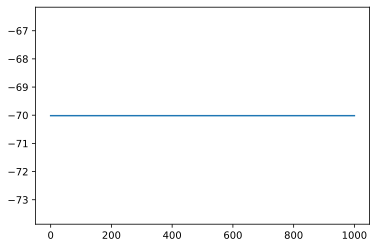

In [38]:
# PLOT OF RESTING CELL (CHECK FOR REMAINING STIMULUS OBJECTS):

ncstim_ = None
soma_v = h.Vector().record(h.soma(0.7)._ref_v)
t_vec = h.Vector().record(h._ref_t)
        
h.finitialize()
h.run()

plt.plot(t_vec, soma_v)

Applying synapses at ~121 um (243.8985804846295 um total)


  0%|          | 0/40 [00:00<?, ?it/s]

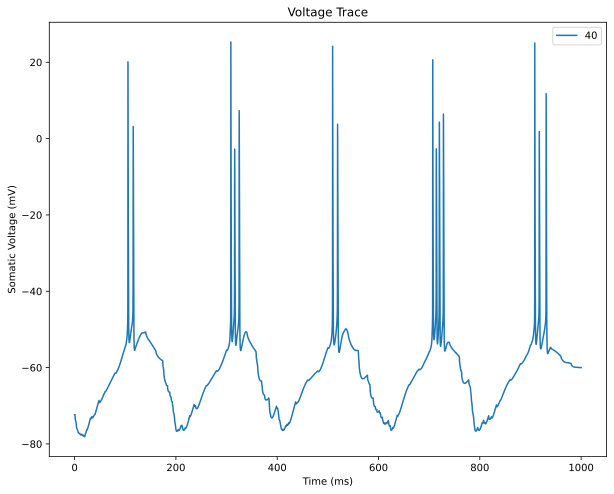

In [60]:
############ TESTING ############

# NOTE: MUST CLEAR NCSTIM_, otherwise, there is OVERLAP!
ncstim_ = None

# apply synapses and analyze voltage traces
h.tstop = 1000

num_s = 40

# stim_param = [interval, num, start, noise, seed]
stim_param =   [1000/50,  1e9,   0,     0,     2]

f, volt, time = apply_syn_cluster(branch=h.a1_111,
                                  measure=h.soma(0.5),
                                  loc=0.5,
                                  n_syn=num_s,
                                  stim_obj=stim_param,
                                  g=[0.0015, 0.0039],
                                  spread=0,
                                  sync=False,
                                  stim_spread=0,
                                  distribute=False,
                                  
                                  g_bouquet=0.01,
                                  loc_bouquet=0.1,
                                  
                                  background_type="Theta",
                                  
                                  g_bg = [0.029, 0, 0.03875, 0, 0],
                                  firing=[5, 5, 50],
                                  dtb=[20, 20],
                                  gamma=True,
                                  
                                  noisy_avg=0.82,
                                  noisy_var=1,
                                  
                                  plot=True,
                                  xlim=1,
                                  ylim=1)

tt = None
current = None
i_c = None
stim_obj = None
ncstim_ = None
tt = None

In [66]:
# FS CURVE #

# NOTE: FOR NONSYNCRHNOUS POISSION, SEED MUST BE 1

# stim_param = [interval, num, start, noise, seed]
stim_param =   [1000/50,  1e9,   0,     0,     1]

num_s = 40

f_1 = increase_syn(branch=h.a1_111, 
                   loc=0.5, 
                   n_syn=num_s,
                   stim=stim_param, 
                   g=[0.0015, 0.0039], 
                   spread=0,
                   stim_spread=0,
                   distribute=False,
                   sync=False,
                   
                   g_bouquet=[0, 0.01],
                   g_bouquet_inc = 0.01,
                   loc_bouquet=[0.1, 0.1],
                   loc_bouquet_inc=0.01,
                   
                   background_type="Noisy",
                   
                   g_bg = [0, 0.00, 0.00, 0, 0.01352],
                   firing = [5, 5, 50],
                   dtb=[20,20],
                   gamma=False,
                   
                   noisy_avg=0.82,
                   noisy_var=1,
                   
                   avg=1, 
                   plot=False, 
                   progress_bar=False)

syn_stim = None
iclamp = None
stim = None
i_c = None
stim_obj = None
ncstim_ = None

Applying synapses at ~121 µm (243.8985804846295 µm total)


  0%|          | 0/1 [00:00<?, ?it/s]

[1.0000000000003617]
[1.0000000000003617, 1.0000000000003617]
[1.0000000000003617, 1.0000000000003617, 1.0000000000003617]
[1.0000000000003617, 1.0000000000003617, 1.0000000000003617, 2.0000000000007234]
[1.0000000000003617, 1.0000000000003617, 1.0000000000003617, 2.0000000000007234, 5.000000000001808]
[1.0000000000003617, 1.0000000000003617, 1.0000000000003617, 2.0000000000007234, 5.000000000001808, 4.000000000001447]
[1.0000000000003617, 1.0000000000003617, 1.0000000000003617, 2.0000000000007234, 5.000000000001808, 4.000000000001447, 3.0000000000010854]
[1.0000000000003617, 1.0000000000003617, 1.0000000000003617, 2.0000000000007234, 5.000000000001808, 4.000000000001447, 3.0000000000010854, 7.000000000002532]
[1.0000000000003617, 1.0000000000003617, 1.0000000000003617, 2.0000000000007234, 5.000000000001808, 4.000000000001447, 3.0000000000010854, 7.000000000002532, 8.000000000002894]
[1.0000000000003617, 1.0000000000003617, 1.0000000000003617, 2.0000000000007234, 5.000000000001808, 4.0

[1.0000000000003617, 1.0000000000003617, 1.0000000000003617, 2.0000000000007234, 5.000000000001808, 4.000000000001447, 3.0000000000010854, 7.000000000002532, 8.000000000002894, 12.000000000004341, 14.000000000005064, 19.00000000000687, 21.000000000007596, 22.000000000007958, 23.00000000000832, 26.000000000009404, 25.00000000000904, 26.000000000009404, 28.00000000001013, 30.00000000001085, 28.00000000001013, 28.00000000001013, 31.000000000011212, 31.000000000011212, 28.00000000001013, 28.00000000001013, 28.00000000001013, 33.00000000001194, 31.000000000011212, 29.00000000001049]
[1.0000000000003617, 1.0000000000003617, 1.0000000000003617, 2.0000000000007234, 5.000000000001808, 4.000000000001447, 3.0000000000010854, 7.000000000002532, 8.000000000002894, 12.000000000004341, 14.000000000005064, 19.00000000000687, 21.000000000007596, 22.000000000007958, 23.00000000000832, 26.000000000009404, 25.00000000000904, 26.000000000009404, 28.00000000001013, 30.00000000001085, 28.00000000001013, 28.0

  0%|          | 0/1 [00:00<?, ?it/s]

[0.0]
[0.0, 0.0]
[0.0, 0.0, 1.0000000000003617]
[0.0, 0.0, 1.0000000000003617, 0.0]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0, 0.0, 4.000000000001447]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0, 0.0, 4.000000000001447, 3.0000000000010854]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0, 0.0, 4.000000000001447, 3.0000000000010854, 7.000000000002532]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0, 0.0, 4.000000000001447, 3.0000000000010854, 7.000000000002532, 9.000000000003256]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0, 0.0, 4.000000000001447, 3.0000000000010854, 7.000000000002532, 9.000000000003256, 11.000000000003979]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0, 0.0, 4.000000000001447, 3.0000000000010854, 7.000000000002532, 9.000000000003256, 11.000000000003979,

[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0, 0.0, 4.000000000001447, 3.0000000000010854, 7.000000000002532, 9.000000000003256, 11.000000000003979, 11.000000000003979, 17.00000000000615, 17.00000000000615, 18.000000000006512, 18.000000000006512, 21.000000000007596, 22.000000000007958, 22.000000000007958, 20.000000000007233, 21.000000000007596, 20.000000000007233, 24.000000000008683, 24.000000000008683, 23.00000000000832, 24.000000000008683, 25.00000000000904, 23.00000000000832, 21.000000000007596, 24.000000000008683, 25.00000000000904, 27.000000000009766, 26.000000000009404]
[0.0, 0.0, 1.0000000000003617, 0.0, 0.0, 0.0, 0.0, 0.0, 4.000000000001447, 3.0000000000010854, 7.000000000002532, 9.000000000003256, 11.000000000003979, 11.000000000003979, 17.00000000000615, 17.00000000000615, 18.000000000006512, 18.000000000006512, 21.000000000007596, 22.000000000007958, 22.000000000007958, 20.000000000007233, 21.000000000007596, 20.000000000007233, 24.000000000008683, 24.000000000008683, 23

In [67]:
f_1

array([[1.0e-01, 0.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 2.0e+00, 5.0e+00,
        4.0e+00, 3.0e+00, 7.0e+00, 8.0e+00, 1.2e+01, 1.4e+01, 1.9e+01,
        2.1e+01, 2.2e+01, 2.3e+01, 2.6e+01, 2.5e+01, 2.6e+01, 2.8e+01,
        3.0e+01, 2.8e+01, 2.8e+01, 3.1e+01, 3.1e+01, 2.8e+01, 2.8e+01,
        2.8e+01, 3.3e+01, 3.1e+01, 2.9e+01, 3.1e+01, 3.4e+01, 3.4e+01,
        3.5e+01, 3.1e+01, 3.6e+01, 2.9e+01, 3.3e+01, 3.8e+01, 3.4e+01],
       [1.0e-01, 1.0e-02, 0.0e+00, 0.0e+00, 1.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 4.0e+00, 3.0e+00, 7.0e+00, 9.0e+00,
        1.1e+01, 1.1e+01, 1.7e+01, 1.7e+01, 1.8e+01, 1.8e+01, 2.1e+01,
        2.2e+01, 2.2e+01, 2.0e+01, 2.1e+01, 2.0e+01, 2.4e+01, 2.4e+01,
        2.3e+01, 2.4e+01, 2.5e+01, 2.3e+01, 2.1e+01, 2.4e+01, 2.5e+01,
        2.7e+01, 2.6e+01, 2.4e+01, 2.7e+01, 2.5e+01, 2.6e+01, 2.8e+01]])

f_run

In [64]:
h.allobjects()

SectionList[0] with 1 refs
SectionList[1] with 1 refs
SectionList[2] with 1 refs
SectionList[3] with 1 refs
SectionList[4] with 1 refs
SectionList[5] with 1 refs
SectionList[6] with 1 refs
SectionList[7] with 1 refs
SectionList[8] with 1 refs
SectionList[9] with 1 refs
SectionList[10] with 1 refs
SectionList[11] with 1 refs
SectionList[12] with 1 refs
SectionList[13] with 1 refs
SectionList[14] with 1 refs
SectionList[15] with 1 refs
SectionList[16] with 1 refs
SectionList[17] with 1 refs
SectionRef[162] with 1 refs
Exp2Syn[1155] with 1 refs
Exp2Syn[1156] with 1 refs
Exp2Syn[1157] with 1 refs
Exp2Syn[1158] with 1 refs
Exp2Syn[1159] with 1 refs
Exp2Syn[1160] with 1 refs
Exp2Syn[1161] with 1 refs
Exp2Syn[1162] with 1 refs
Exp2Syn[1163] with 1 refs
Exp2Syn[1164] with 1 refs
Exp2Syn[1165] with 1 refs
Exp2Syn[1166] with 1 refs
Exp2Syn[1167] with 1 refs
Exp2Syn[1168] with 1 refs
Exp2Syn[1169] with 1 refs
Exp2Syn[1170] with 1 refs
Exp2Syn[1171] with 1 refs
Exp2Syn[1172] with 1 refs
Exp2Syn[11

0.0